In [213]:
import numpy as np 
import pandas as pd 

In [214]:
train = pd.read_csv("data/train.csv",sep=",",encoding="latin1")
val = pd.read_csv("data/val.csv",sep=",",encoding="latin1")
test = pd.read_csv("data/test.csv",sep=",",encoding="latin1")

In [215]:
train.head()

,Unnamed: 0,Sentence #,Word,Tag
0,0,Sentence: 1,Italian,B-gpe
1,1,Sentence: 1,police,O
2,2,Sentence: 1,led,O
3,3,Sentence: 1,the,O
4,4,Sentence: 1,operation,O


In [216]:
val.head()

,Unnamed: 0,Sentence #,Word,Tag
0,0,Sentence: 1,The,O
1,1,Sentence: 1,Kurdish,O
2,2,Sentence: 1,party,O
3,3,Sentence: 1,has,O
4,4,Sentence: 1,fought,O


In [217]:
test.head()

,Unnamed: 0,Sentence #,Word,Tag
0,0,Sentence: 1,The,O
1,1,Sentence: 1,report,O
2,2,Sentence: 1,calls,O
3,3,Sentence: 1,on,O
4,4,Sentence: 1,President,B-per


In [218]:
train.Tag.value_counts()

O        533772
B-geo     22612
B-tim     12196
B-org     12051
I-per     10393
B-per     10190
I-org     10159
B-gpe      9642
I-geo      4441
I-tim      3983
B-art       221
B-eve       182
I-art       157
I-eve       140
B-nat       135
I-gpe       132
I-nat        30
Name: Tag, dtype: int64

In [219]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630436 entries, 0 to 630435
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  630436 non-null  int64 
 1   Sentence #  630436 non-null  object
 2   Word        630436 non-null  object
 3   Tag         630436 non-null  object
dtypes: int64(1), object(3)
memory usage: 19.2+ MB


In [220]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [222]:
train_getter = SentenceGetter(train)
val_getter = SentenceGetter(val)
test_getter = SentenceGetter(test)

In [223]:
train_sentences = train_getter.sentences
val_sentences = val_getter.sentences
test_sentences = test_getter.sentences

In [224]:
print(train_sentences[0])

[('Italian', 'B-gpe'), ('police', 'O'), ('led', 'O'), ('the', 'O'), ('operation', 'O'), (',', 'O'), ('arresting', 'O'), ('41', 'O'), ('Bulgarian', 'B-gpe'), ('nationals', 'O'), ('in', 'O'), ('Italy', 'B-geo'), (',', 'O'), ('Bulgaria', 'B-geo'), (',', 'O'), ('Austria', 'B-geo'), (',', 'O'), ('and', 'O'), ('Germany', 'B-geo'), ('.', 'O')]


In [225]:
maxlen = max([len(s) for s in train_sentences + val_sentences + test_sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 104


In [226]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

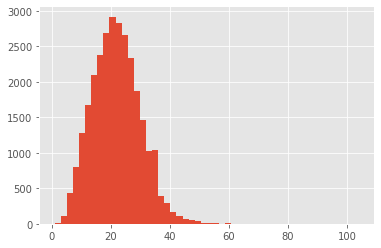

In [227]:
plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

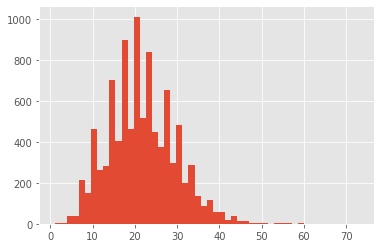

In [228]:
plt.hist([len(s) for s in val_sentences], bins=50)
plt.show()

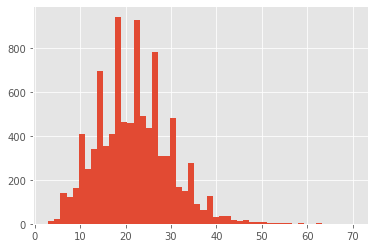

In [229]:
plt.hist([len(s) for s in test_sentences], bins=50)
plt.show()

In [255]:
words = list(set(train["Word"].values.tolist() + val["Word"].values.tolist() + test["Word"].values.tolist()))
words.append("ENDPAD")

In [256]:
n_words = len(words)
print(n_words)

35179


In [258]:
tags = list(set(train["Tag"].values))

In [259]:
n_tags = len(tags)
print(n_tags)

17


In [260]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [261]:
from keras.preprocessing.sequence import pad_sequences
X_train = [[word2idx[w[0]] for w in s] for s in train_sentences]
X_val = [[word2idx[w[0]] for w in s] for s in val_sentences]
X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]

In [262]:
X_train = pad_sequences(maxlen=maxlen, sequences=X_train, padding="post",value=n_words - 1)
X_val = pad_sequences(maxlen=maxlen, sequences=X_val, padding="post",value=n_words - 1)
X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=n_words - 1)

In [263]:
y_train = [[tag2idx[w[1]] for w in s] for s in train_sentences]
y_val = [[tag2idx[w[1]] for w in s] for s in val_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [264]:
y_train = pad_sequences(maxlen=maxlen, sequences=y_train, padding="post", value=tag2idx["O"])
y_val = pad_sequences(maxlen=maxlen, sequences=y_val, padding="post", value=tag2idx["O"])
y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

In [265]:
from keras.utils import to_categorical
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]
y_val = [to_categorical(i, num_classes=n_tags) for i in y_val]
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]

In [266]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense

In [267]:
input = Input(shape=(maxlen,))
model = Embedding(input_dim=n_words, output_dim=maxlen, input_length=maxlen)(input)
model = LSTM(units=100, return_sequences=True, input_shape=(104, 104))(model)
out = Dense(n_tags, activation="softmax")(model)  # softmax output layer

In [268]:
model = Model(input, out)

In [269]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 104, 104)          3658616   
_________________________________________________________________
lstm_7 (LSTM)                (None, 104, 100)          82000     
_________________________________________________________________
dense_7 (Dense)              (None, 104, 17)           1717      
Total params: 3,742,333
Trainable params: 3,742,333
Non-trainable params: 0
_________________________________________________________________


In [270]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [271]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1_m])

In [274]:
history = model.fit(X_train, np.array(y_train), validation_data=(X_val, np.array(y_val)), batch_size=32, epochs=5, verbose=1)

D:\Anaconda\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28775 samples, validate on 9592 samples
Epoch 1/5
28775/28775 [==============================] - 101s 3ms/step - loss: 0.1453 - accuracy: 0.9724 - f1_m: 0.9619 - val_loss: 0.0597 - val_accuracy: 0.9854 - val_f1_m: 0.9848
Epoch 2/5
28775/28775 [==============================] - 97s 3ms/step - loss: 0.0402 - accuracy: 0.9897 - f1_m: 0.9895 - val_loss: 0.0332 - val_accuracy: 0.9910 - val_f1_m: 0.9909
Epoch 3/5
28775/28775 [==============================] - 98s 3ms/step - loss: 0.0253 - accuracy: 0.9927 - f1_m: 0.9926 - val_loss: 0.0289 - val_accuracy: 0.9915 - val_f1_m: 0.9916
Epoch 4/5
28775/28775 [==============================] - 98s 3ms/step - loss: 0.0204 - accuracy: 0.9936 - f1_m: 0.9937 - val_loss: 0.0282 - val_accuracy: 0.9916 - val_f1_m: 0.9917
Epoch 5/5
28775/28775 [==============================] - 98s 3ms/step - loss: 0.0177 - accuracy: 0.9943 - f1_m: 0.9944 - val_loss: 0.0286 - val_accuracy: 0.9916 - val_f1_m: 0.9917


In [ ]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))


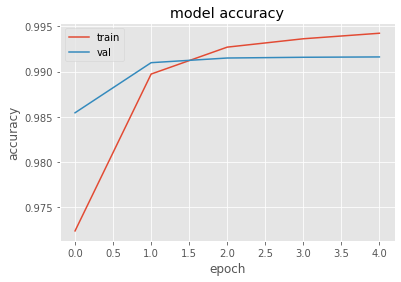

In [278]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

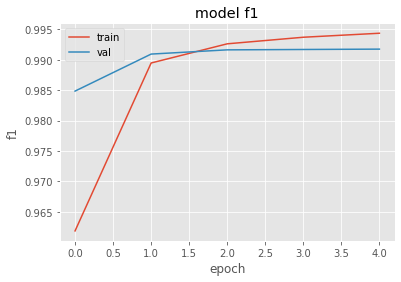

In [279]:
plt.plot(history.history["f1_m"])
plt.plot(history.history["val_f1_m"])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

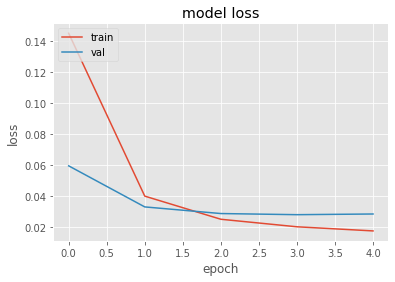

In [280]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [282]:
scores = model.evaluate(X_test, np.array(y_test), verbose=1)

9592/9592 [==============================] - 8s 843us/step


In [288]:
for i in range(len(scores)):
    print("test %s: %.2f%%" % (model.metrics_names[i], scores[i] * 100))

test loss: 2.90%
test accuracy: 99.15%
test f1_m: 99.17%
